In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from nearestPD import nearestPD


ds_2 = xr.open_dataset("data/regions_verify_202104_cov.nc")
bio_2 = ds_2["covariance_bio"]
anth_2 = ds_2["covariance_anth"]

M = anth_2
# determine threshold
thresh = 10**(-8)

# new thresholded matrix
M0 = np.where(abs(M) < thresh, 0, M)

# nearest non-singular to M0

#M0pd = nearestPD(M0)

#M0i = np.linalg.inv(M0)
# %timeit np.linalg.inv(M)



Visual check
* where the non-zero elements of the matrix are after setting the threshold
* nearest nonsingular 

Text(3.1999999999999993, 0.5, 'nstate')

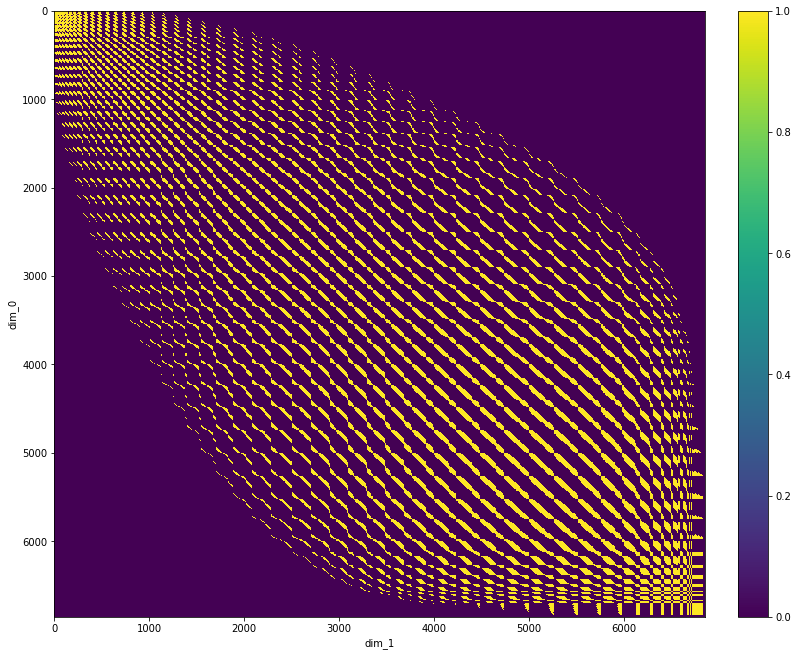

In [22]:



M0_binary = np.where(M0 != 0.0, 1.0, M0)
M0_binary = xr.DataArray(M0_binary)




fig, ax = plt.subplots(figsize = (11,9), layout= 'constrained')
M0_binary.plot.pcolormesh(yincrease = False)
ax.set_xlabel("nstate")
ax.set_ylabel("nstate")
plt.show()


#fig, ax = plt.subplots(layout = 'constrained')
#M0pd_binary.plot.pcolormesh(yincrease = False)





<xarray.DataArray ()>
array(0.) 0.0 0.24086587722293312 <xarray.DataArray ()>
array(0.8)


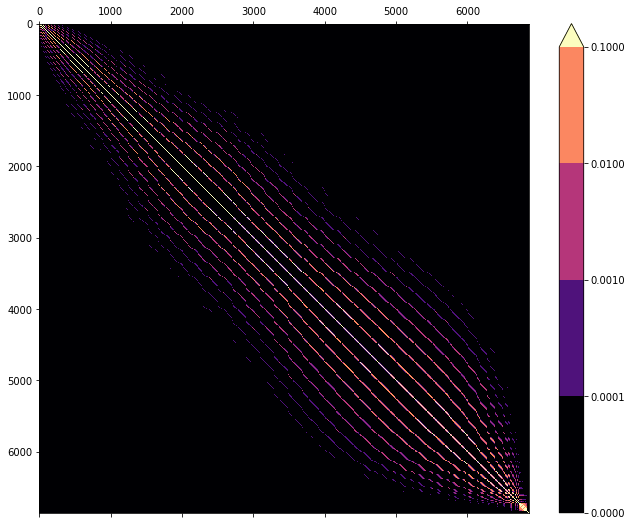

In [10]:
M0 = xr.DataArray(M0)
qlower = np.quantile(M0, 0.001)
qupper = np.quantile(M0, 0.999)
vmin = np.min(M0)
vmax = np.max(M0)
print(vmin, qlower, qupper, vmax)

fig, ax = plt.subplots(figsize = (11,9))
bounds = np.array([0., 1e-4, 1e-3, 1e-2, 1e-1])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='max')
pcm = ax.matshow(M0, norm=norm, cmap='magma')
# The colorbar inherits the "extend" argument from BoundaryNorm.
fig.colorbar(pcm, ax=ax, orientation='vertical')
plt.show()

Yksinkertainen blokkijako
---------------------------

* Huom! Jos muissakin matriiseissa alakulma leveämpi, voisi olla fiksumpaa laittaa alakulmaan ne isommat blockit. Nyt ovat yläkulmassa
* Inversionin vois oikeestaan tehdä in-place ja samalla muuttaa nolliksi kaikki muut arvot
* Vai onko parempi koota uusi block_diag matriisi käännetyistä? (vrt. ei tarvitse ladata koko matriisia muistiin)

In [16]:
def get_blocks(M, nblock):
    """Partition the area around the diagonal of matrix M into nblock blocks of
    approximately equal size."""
    n = len(M)
    bsize = n//nblock
    nrem = n%nblock #remainder
    ls = []
    startb = 0 #index where the first block starts on the diagonal
    for i in np.arange(nblock):
        # nrow/ncol of the first nrem blocks is bsize+1
        if i <= nrem-1:
            endb = startb+bsize+1 #index for end of block
        else:
           endb = startb+bsize 
        block = M[startb:endb, startb:endb]
        ls.append(block)
        startb = endb # the coordinate for the end of the block is the start of the new block
    return ls


def combine_inverted(blocks, n):
    invm = np.linalg.inv
    for i in np.arange(len(blocks)):
        blocks[i] = invm(blocks[i])
    return blocks



[[0.5 0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0. ]
 [0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.5]]

[[0.5 0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0. ]
 [0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.5]]

[[0.5 0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0. ]
 [0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.5]]

[[0.5 0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0. ]
 [0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.5]]

[[0.5 0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0. ]
 [0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.5]]



Tests to see if functions work as intended
-------------------------------------------

In [17]:

nblocks = 4

A = np.diag(np.ones(25)*2)
blocks = get_blocks(A, nblocks)
for i in range(nblocks):
    print(blocks[i])
    print()


blocks_inverted = combine_inverted(blocks, 25)
for i in range(nblocks):
    print(blocks_inverted[i])
    print()



[[2. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 2.]]

[[2. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 2.]]

[[2. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 2.]]

[[2. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 2.]]

[[0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.5]]

[[0.5 0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.5]]

[[0.5 0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0. ]
 [0.  0. 

In [ ]:
blocks = get_blocks(M.values,7)

block = xr.DataArray(blocks[6])

fig, ax = plt.subplots(figsize = (9,11))
bounds = np.array([0., 1e-4, 1e-3, 1e-2, 1e-1, 0.8])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='max')
pcm = ax.matshow(block, norm=norm, cmap='magma')
# The colorbar inherits the "extend" argument from BoundaryNorm.
fig.colorbar(pcm, ax=ax, orientation='vertical')
plt.show()

